# O problema do desbalanceamento

Imagine que você começou o estudo de um conjunto de dados, e criou um modelo bem simples para te servir de *baseline*. Neste modelo, você usou só uma *feature* e usou todos os hiperparâmetros *default*. Você, então, testa este modelo no seu conjunto de testes, e *ele tem acurácia de 90%!*

### O que está estranho?

Talvez você tenha muita sorte, mas é muito mais provável que você tenha deixado de olhar o *balanceamento* das suas classes. Vamos supor um caso muito comum de desbalanceamento de classes: o de fraudes em cartão de crédito. Considere que 90% das transações não são fraudes, e 10% são. Se o seu modelo classificar todas as transações como não fraudes, sua acurácia seria de 90%!

### Qual o problema disso?

Se o seu modelo chuta sempre a classe majoritária, ele pode até acertar uma boa parte dos casos, mas na maioria dos problemas desbalanceados nosso interesse maior é na classe *minoritária* (ou seja, a que tem menos exemplos). Um modelo para detecção de fraudes seria inútil se sempre chutasse que uma transação não é uma fraude: mesmo acertando na maioria das vezes, ele sempre deixaria as fraudes passarem.

### Como corrigir isso?

Neste notebook, vamos comparar algumas técnicas de balanceamento e discutiremos como medir a eficácia destas técnicas.

# Problema: classificação de vidros

Para explorarmos duas técnicas de balanceamento, iremos utilizar o *dataset* "Glass Classification" (classificação de vidros), da UCI, disponível [neste link](https://raw.githubusercontent.com/p-sama/Glass-Classification/master/glass.csv).

In [2]:
import pandas as pd
glass = pd.read_csv("https://raw.githubusercontent.com/p-sama/Glass-Classification/master/glass.csv")
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


O conjunto de dados em questão é formado por 214 exemplos, 9 *features* e a classe que devemos prever (*Type*). Cada exemplo representa um vidro diferente, cada *feature* traz a medição de um elemento químico no vidro em questão, e cada vidro pode ser classificado em 1 entre 7 tipos diferentes. Clique [aqui](https://archive.ics.uci.edu/ml/datasets/glass+identification) para entender um pouco mais sobre o conjunto de dados.

Abaixo, podemos ver algumas informações importantes sobre cada coluna:

In [3]:
glass.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Observando a contagem de valores preenchidos (primeira linha), vemos que felizmente não temos valores faltantes no conjunto de dados, e todas as 214 linhas estão completamente preenchidas. 

No entanto, perceba que algumas colunas possuem uma extensão de valores muito maior do que outras. Tome como exemplo a coluna Si e a coluna K. Na média, já percebemos uma diferença significativa, que fica ainda mais clara olhando os percentis. Por isso, precisaremos trabalhar um pouco com os dados antes de utilizá-los no nosso modelo (aplicaremos o *z-score* a cada valor para deixá-los na mesma escala).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


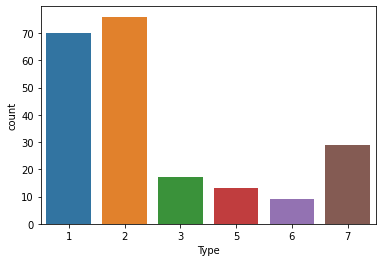

In [4]:
import seaborn as sns
sns.countplot(glass.Type)

In [27]:
#@title Pré-processamento
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

y = glass.Type 
glass_features = [i for i in glass.columns if i not in ['Type']]
X = glass[glass_features]

numerical_cols = [glass_features[i] for i in range(len(glass_features)) if glass[glass_features[i]].dtype not in ['object', 'bool']]

scaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', scaler_transformer, numerical_cols)
    ])

from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=1000)

# Comparações
## Antes e depois do balanceamento: o que mudou?

Vamos fazer as seguintes comparações:
- Acurácia do modelo antes do balanceamento, depois do balanceamento com OverSampler, depois do balanceamento com UnderSampler e utilizando Stratified Cross-validation;
- AUC antes do balanceamento, depois do balanceamento com OverSampler, depois do balanceamento com UnderSampler e utilizando Stratified Cross-validation;
- F1-score antes do balanceamento, depois do balanceamento com OverSampler,depois do balanceamento com UnderSampler e utilizando Stratified Cross-validation.

(Obs.: utilizaremos o Cross-Validation para todos para que tenhamos mais confiança no resultado. Não iremos, no entanto, utilizar o CV estratificado em todos, apenas no último. Para fins de comparação, quando utilizarmos o CV estratificado, utilizaremos o dataset desbalanceado).


In [29]:
warnings.filterwarnings('ignore')

#bibliotecas de métodos de balanceamento
from imblearn.pipeline import Pipeline #pipeline do imblearn
from imblearn.over_sampling import RandomOverSampler #over sampler
from imblearn.under_sampling import ClusterCentroids #under sampler
from sklearn.model_selection import cross_val_score #cross-val
from sklearn.metrics import plot_confusion_matrix #matriz de confusão

#pipeline desbalanceado
imb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

#pipeline com RandomOversampler (oversampler)
over_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('oversampler', RandomOverSampler()),
                              ('model', model)])

#pipeline com ClusterCentroids (undersampler)
under_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('oversampler', ClusterCentroids()),
                              ('model', model)])

## 1. Acurácia: antes e depois

Acurácia: não deve melhorar muito.

In [30]:
warnings.filterwarnings('ignore')

imb_auc = cross_val_score(imb_pipeline, X, y, cv=5, scoring='accuracy').mean()
over_auc = cross_val_score(over_pipeline, X, y, cv=5, scoring='accuracy').mean()
under_auc = cross_val_score(under_pipeline, X, y, cv=5, scoring='accuracy').mean()

print('IMB: ' + str(round(imb_auc*100, 2))+'%')
print('UNDER: ' + str(round(under_auc*100, 2))+'%')
print('OVER: ' + str(round(over_auc*100, 2))+'%')

IMB: 69.2%
UNDER: 43.05%
OVER: 71.98%


## 2. F1: antes e depois
Agora, vamos olhar se algo muda no F1 quanto aplicamos diferentes técnicas de balanceamento.

In [31]:
warnings.filterwarnings('ignore')

imb_auc = cross_val_score(imb_pipeline, X, y, cv=5, scoring='f1_micro').mean()
over_auc = cross_val_score(over_pipeline, X, y, cv=5, scoring='f1_micro').mean()
under_auc = cross_val_score(under_pipeline, X, y, cv=5, scoring='f1_micro').mean()

print('IMB: ' + str(round(imb_auc*100, 2))+'%')
print('UNDER: ' + str(round(under_auc*100, 2))+'%')
print('OVER: ' + str(round(over_auc*100, 2))+'%')

IMB: 69.2%
UNDER: 45.36%
OVER: 70.59%


# Conclusões

Não sei kk